In [3]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

import numpy as np

from cvxopt import matrix, solvers

from tools import Data, Predictions


""" A PDF reweighting tool """

__author__ = 'Stefano Carrazza & Zahari Kassabov'
__license__ = 'GPL'
__version__ = '1.0.0'
__email__ = 'stefano.carrazza@cern.ch'




In [53]:
def effective_number_of_replicas(w):
    N = len(w)
    w = w*N
    return np.exp(np.nansum(w*np.log(N/w))/N)

In [5]:
effective_number_of_replicas(np.ones(100))

1.0

In [77]:
def chi2_per_replica(sigma, cv, predictions):
    diff = predictions - cv
    return np.einsum('id,de,ie -> i',diff, sigma, diff )/len(sigma)

In [122]:
def nnpdf_weights(sigma, cv, predictions):
    chi2s = chi2_per_replica(sigma, cv, predictions)*len(sigma)
    logw = ((len(sigma) - 1)/2)*np.log(chi2s) - 0.5*chi2s
    logw -= np.mean(logw)
    w = np.exp(logw)
    w /= sum(w)
    return w

In [123]:
nnpdf_weights(sigma, cv, predictions)

array([  3.03367609e-07,   1.90305380e-11,   2.31125771e-22,
         2.44626424e-14,   7.22385005e-28,   7.10635407e-08,
         1.32540552e-13,   1.39811793e-11,   6.88222395e-11,
         3.01203312e-39,   7.86810627e-35,   2.27151855e-17,
         5.52207313e-23,   5.44392390e-26,   1.67225417e-20,
         1.56035279e-08,   8.63529062e-50,   2.13273147e-12,
         2.42305439e-04,   2.14200143e-27,   5.00953096e-17,
         3.22933280e-08,   4.01709191e-23,   4.76801862e-22,
         3.16981646e-09,   2.92985378e-31,   6.99250852e-21,
         2.33100211e-16,   8.09265731e-07,   9.21372878e-01,
         1.77462374e-24,   9.11749979e-37,   4.90772418e-23,
         1.21825020e-21,   5.29937392e-14,   4.86460894e-04,
         3.20028192e-23,   8.44118019e-28,   3.65028051e-26,
         5.62146769e-02,   2.08496004e-05,   5.17088018e-11,
         7.90573390e-17,   2.13831457e-13,   4.34777126e-15,
         3.64017611e-25,   1.75680229e-13,   5.18572438e-10,
         4.72547457e-28,

In [124]:
effective_number_of_replicas(_)

1.3870304461522009

In [76]:
len(diff)

100

In [75]:
d = diff[0,:]

(4076,)

In [106]:
chis = chi2_per_replica(sigma, cv, predictions)*len(sigma)

In [114]:
logw = np.log(chis)*((len(sigma) - 1)/2) - 0.5*chis
logw -= np.mean(logw)
w = np.exp(logw)
w /= sum(w)

In [115]:
w

array([  3.03367609e-07,   1.90305380e-11,   2.31125771e-22,
         2.44626424e-14,   7.22385005e-28,   7.10635407e-08,
         1.32540552e-13,   1.39811793e-11,   6.88222395e-11,
         3.01203312e-39,   7.86810627e-35,   2.27151855e-17,
         5.52207313e-23,   5.44392390e-26,   1.67225417e-20,
         1.56035279e-08,   8.63529062e-50,   2.13273147e-12,
         2.42305439e-04,   2.14200143e-27,   5.00953096e-17,
         3.22933280e-08,   4.01709191e-23,   4.76801862e-22,
         3.16981646e-09,   2.92985378e-31,   6.99250852e-21,
         2.33100211e-16,   8.09265731e-07,   9.21372878e-01,
         1.77462374e-24,   9.11749979e-37,   4.90772418e-23,
         1.21825020e-21,   5.29937392e-14,   4.86460894e-04,
         3.20028192e-23,   8.44118019e-28,   3.65028051e-26,
         5.62146769e-02,   2.08496004e-05,   5.17088018e-11,
         7.90573390e-17,   2.13831457e-13,   4.34777126e-15,
         3.64017611e-25,   1.75680229e-13,   5.18572438e-10,
         4.72547457e-28,

In [121]:
np.min(chis)/len(sigma)

1.2676258096220598

In [113]:
effective_number_of_replicas(_)

1.3870304461522009

In [105]:
chis

array([ 1.30070181,  1.3207169 ,  1.36880225,  1.33395197,  1.39137286,
        1.30376778,  1.33063014,  1.32133899,  1.31811342,  1.43531815,
        1.41864914,  1.3474241 ,  1.37140102,  1.38378473,  1.36094887,
        1.30694532,  1.4734284 ,  1.32511319,  1.28626072,  1.38947467,
        1.34591766,  1.305424  ,  1.37197683,  1.36748264,  1.31025892,
        1.40482359,  1.36255826,  1.34297503,  1.29861544,  1.26762581,
        1.3775881 ,  1.42601145,  1.37161453,  1.36576802,  1.33243538,
        1.28472219,  1.3723878 ,  1.3911013 ,  1.38449095,  1.27405898,
        1.29162516,  1.31869384,  1.34504642,  1.32968531,  1.3373226 ,
        1.38041449,  1.33007377,  1.31399026,  1.39211226,  1.31566485,
        1.2991891 ,  1.34180112,  1.41846573,  1.47130641,  1.34581823,
        1.34479554,  1.30577922,  1.32114324,  1.43566747,  1.28836072,
        1.42900827,  1.37815705,  1.46441624,  1.39085998,  1.47786683,
        1.35630795,  1.43032868,  1.33436966,  1.48071631,  1.35

In [6]:
def chi2(w, sigma, cv, predictions):

    w = np.ravel(w)
    diff = w@predictions - cv

    chi2 = diff@sigma@diff/len(diff)

    return chi2

In [67]:
# load data, invcovmat and predictions
dt = Data('data/data.csv.tgz', 'data/invcovmat.csv.tgz')
th = Predictions('data/predictions.csv.tgz')

# retreive cv and invcovmat as numpy arrays
cv    = dt.get_data()
sigma = dt.get_invcovmat()
predictions     = th.get_predictions()


 Opening data file: data/data.csv.tgz
 Opening data file: data/invcovmat.csv.tgz
 Opening predictions file: data/predictions.csv.tgz


The chi² function is

v = (w@P) - cv
chi² = v@sigma@v

Therefore we need to minimize 1/2*w@P@W + q@w as a function of w


In [23]:

P = predictions@sigma@predictions.T + np.eye(len(predictions))*10000
q = -cv@sigma@predictions.T
A = np.ones_like(P[0])

#b = np.zeros_like(P[0])
b = float(1)

G = -np.eye(len(A))

h = np.zeros(len(A))


P = matrix(P)
q = matrix(q)
A = matrix(A)
b = matrix(b)
G = matrix(G)
h = matrix(h)

solvers.options['feastol'] = 1e-12
sol = solvers.qp(P, q, G, h, A.T, b)

w = np.array(sol['x']).ravel()



     pcost       dcost       gap    pres   dres
 0: -1.6842e+05 -1.6842e+05  1e+02  1e+01  3e-06
 1: -1.6842e+05 -1.6842e+05  2e+00  1e-01  4e-08
 2: -1.6842e+05 -1.6842e+05  8e-01  4e-02  1e-08
 3: -1.6842e+05 -1.6842e+05  2e+00  2e-02  6e-09
 4: -1.6842e+05 -1.6842e+05  1e+00  5e-16  3e-16
 5: -1.6842e+05 -1.6842e+05  3e-02  6e-17  3e-16
Optimal solution found.


In [24]:
np.sum(w)

1.0

In [25]:
(w > 0).all()

True

In [26]:
%matplotlib inline

In [27]:
w.min()

3.5908728147983684e-06

In [28]:
w.max()

0.021144801406802732

In [29]:
np.sort(w)

array([  3.59087281e-06,   2.52704109e-05,   2.19581125e-04,
         4.80688987e-04,   2.19105472e-03,   2.85863955e-03,
         3.42736953e-03,   3.54817635e-03,   3.96407607e-03,
         4.12420993e-03,   4.17012230e-03,   4.42138958e-03,
         4.58889737e-03,   4.70487875e-03,   4.72213755e-03,
         4.89981035e-03,   4.93870037e-03,   5.22149004e-03,
         5.51112353e-03,   5.62746743e-03,   5.72185204e-03,
         5.80385148e-03,   5.88064205e-03,   5.91079999e-03,
         6.16573048e-03,   6.18014027e-03,   6.50627789e-03,
         6.83130371e-03,   6.90783392e-03,   6.97816017e-03,
         6.99828875e-03,   7.76442913e-03,   7.85352075e-03,
         7.89956134e-03,   7.91271406e-03,   8.27113891e-03,
         8.27425071e-03,   8.38685128e-03,   8.40799212e-03,
         8.63052756e-03,   8.90904124e-03,   9.01868879e-03,
         9.04705550e-03,   9.18751833e-03,   9.29932820e-03,
         9.44543236e-03,   9.54346032e-03,   9.60498291e-03,
         9.61476347e-03,

In [30]:
np.median(w)

0.0098725242614162122

In [31]:
np.argsort(w)[-15:]

array([ 0, 91, 21, 39, 15,  6,  5, 83, 97, 24, 44, 96, 29, 56, 35])

In [32]:
chi2(w, sigma, cv, predictions)

1.2502810132321627

In [33]:
np.mean(predictions, axis=0)@sigma@np.mean(predictions, axis=0)

344078.13949489093

In [34]:
effective_number_of_replicas(w)

87.884770091865832

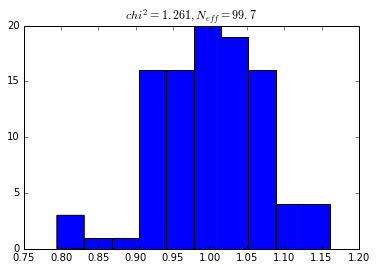

In [79]:
%matplotlib inline
import matplotlib.pyplot as plt
from ipywidgets import interact
solvers.options['show_progress'] = False
def show_sol(penalty=0):
    P = predictions@sigma@predictions.T + np.eye(len(predictions))*penalty
    P = matrix(P)
    sol = solvers.qp(P, q, G, h, A.T, b)
    w = np.array(sol['x']).ravel()
    plt.title("$chi^2=%.3f, N_{eff}=%.1f$" % (chi2(w, predictions=predictions, 
                                                   cv=cv, sigma=sigma),
                                              effective_number_of_replicas(w)))
    w*=len(A)
    plt.hist(w)

interact(show_sol, penalty=(0,80000))
    



